### Mccreight - suffixlinks
Mccreight enables us to contruct a suffixtree in linear time O(n). This is done by switching between a fast and slow search for when looking if a current suffix fits into the tree. this is done by using a suffix link. the link in short allows us to jump to where a suffix should be inserted instead of looking through the tree from the root again

Visualization saved as Suffix_tree_compressed.png


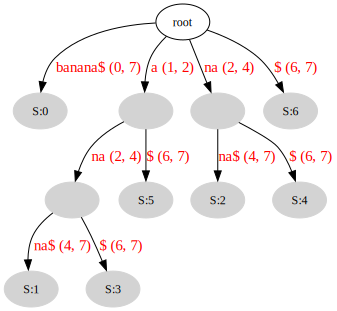

In [38]:
######## Normal original version O(n^2)


class Node(object):
    def __init__(self, start=None, end=None, suffix_number=None, parent=None):
        self.start = start                      # start idx for string
        self.end = end                          # end idx for string 
        self.suffix_number = suffix_number      # order the $ are add to tree
        self.children = {}                      # children as dictionary, key = a unique charater, value = Npde(object)
        self.parent = parent                    # Defining a parent node allows us to go back up in the tree
        #self.suffixlink =   # <---- for mccreicht  
    
class SuffixTree:
    def __init__(self, string):
        self.string = string + "$"
        self.root = Node()
        self.build_tree(string)
    
    
    def build_tree(self, string):
        string = string + "$"
        n = len(string)
        
        for i in range(n):
            current_node = self.root
            suffix = string[i:]
            self.insert_suffix(current_node, suffix, i, i)
    
    def insert_suffix(self, current_node, suffix, suffix_start, suffix_index):
        first_char = suffix[0]

        ### outgoing edge - check if suffix has an edge it can follow
        #case 1: No children matching suffix - so we add one
        if first_char not in current_node.children:
            current_node.children[first_char] = Node(suffix_start, len(self.string), suffix_index, current_node)       
        
        #case2: We have an outgoing edge!
        elif first_char in current_node.children:
            edge_node = current_node.children[first_char] # move down to the node we found
            common_len = self.find_common_prefix_length(suffix, edge_node)
            #case2.1: if we moved all the way out of the edge
            if common_len == edge_node.end - edge_node.start:
                self.insert_suffix(edge_node, suffix[common_len:], suffix_start+common_len, suffix_index)
            #case2.2: split in edge found, insert internal node 
            else:
                self.split_edge(current_node, edge_node, common_len, suffix, suffix_start, suffix_index)


    def find_common_prefix_length(self, suffix, edge):
        """
        Find the length of a common prefix between two strings
        """
        common_len = 0
        edge_start = edge.start
        edge_end = edge.end
        
        # while we dont exceed the suffix length
        while common_len < len(suffix) and edge_start + common_len < edge_end:
            if suffix[common_len] == self.string[edge_start + common_len]:        # if the letters in suffix and string is the same -> contentiue
                common_len += 1
            else:
                break   # end when no longer the same, this is our breaking index where we split
        return common_len

    def split_edge(self, parent_node, edge, common_length, suffix, suffix_start, suffix_index):
        """
        we found a missmatch and insert a new node inbetween existing childnode and parent
        This new internal node becomes new child of the current parent node and parent to current child node
        Then we add the remainder of the current suffix as a new child node (now sibling to old childnode)
        """
        #create the new internal node - will be the parent of the split edge and the new leaf
        internal_node = Node(start=edge.start, end=edge.start + common_length, parent=parent_node) # it idx ends at the common lenght from where it starts
        parent_node.children[self.string[edge.start]] = internal_node

        # update the existing edge's start
        edge.start += common_length # leaf node now starts at the new split
        edge.parent = internal_node
        internal_node.children[self.string[edge.start]] = edge
        
        # create new leaf node with rest of current suffix
        remaining_suffix_start = suffix_start + common_length
        internal_node.children[suffix[common_length]] = Node(start=remaining_suffix_start, end=len(self.string), suffix_number=suffix_index, parent=internal_node)

####################################
### Visualization using graphviz ###
    def visualize(self, filename="Suffix_tree_compressed"):
        dot = Digraph(node_attr={'shape': 'ellipse', 'fontsize': '12', 'fixedsize': 'false'},
                      edge_attr={'fontsize': '15', 'fontcolor': 'red', 'labelfontsize': '10', 
                                 'labeldistance': '1', 'labelangle': '0'})
        self.add_edges(dot, self.root, node_id="root")
        dot.render(filename, format='png', cleanup=True)    # saves an image of the tree in root folder
        print(f"Visualization saved as {filename}.png")
        return dot

    def add_edges(self, dot, node, node_id):
        #add each child and its corresponding edge label
        for i, (char, child) in enumerate(node.children.items()):
            child_id = f"{node_id}_{i}"  # unique id for each child node

            # check if df_numbering has been added
            if hasattr(child, 'df_number'):
            # check if the child is a leaf
                if not child.children:  #Leaf node (no children)
                    leaf_label = f"S:{child.suffix_number}, df:{child.df_number}"
                    dot.node(child_id, leaf_label, style="filled", color="lightgrey")
                else:
                    dot.node(child_id, "", style="filled", color="lightgrey")  # Internal nodes remain unlabeled
            else:
                if not child.children:  #Leaf node (no children)
                    leaf_label = f"S:{child.suffix_number}"
                    dot.node(child_id, leaf_label, style="filled", color="lightgrey")
                else:
                    dot.node(child_id, "", style="filled", color="lightgrey")  # Internal nodes remain unlabeled
            
            #edge label
            #label = self.string[child.start:child.end]     # write the string labels
            #label = f"({child.start}, {child.end})"         # write the idx on labels
            label = self.string[child.start:child.end] + f" ({child.start}, {child.end})" 
            dot.edge(node_id, child_id, label=label)

            # Recursively add edges for the child
            self.add_edges(dot, child, child_id)  
   



test_string = "banana"

suffix_tree = SuffixTree(test_string)
suffix_tree.visualize()

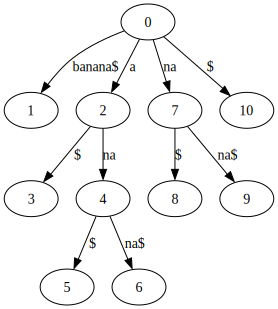

In [39]:
from graphviz import Digraph

class SuffixTreeNode_mc:
    def __init__(self):
        self.children = {}  # Key: edge label, Value: child node
        self.suffix_link = None  # Link to another node
        self.start = -1  # Start index of edge label
        self.end = -1  # End index of edge label

class SuffixTree_mc:
    def __init__(self, text):
        self.text = text + "$"
        self.root = SuffixTreeNode_mc()
        self.active_node = self.root
        self.active_edge = 0
        self.active_length = 0
        self.remaining_suffix_count = 0
        self.last_created_node = None
        self.construct_tree()

    def construct_tree(self):
        for i in range(len(self.text)):
            self.add_suffix(i)

    def add_suffix(self, pos):
        self.last_created_node = None
        self.remaining_suffix_count += 1

        while self.remaining_suffix_count > 0:
            if self.active_length == 0:
                self.active_edge = pos

            # Check if the edge starting with the active_edge character exists
            if self.text[self.active_edge] not in self.active_node.children:
                # Create a new edge and node
                new_node = SuffixTreeNode_mc()
                new_node.start = pos
                new_node.end = len(self.text)
                self.active_node.children[self.text[self.active_edge]] = new_node

                # Create a suffix link from the last created internal node
                if self.last_created_node is not None:
                    self.last_created_node.suffix_link = self.active_node
                    self.last_created_node = None
            else:
                next_node = self.active_node.children[self.text[self.active_edge]]
                edge_length = next_node.end - next_node.start

                if self.active_length >= edge_length:
                    self.active_edge += edge_length
                    self.active_length -= edge_length
                    self.active_node = next_node
                    continue

                if self.text[next_node.start + self.active_length] == self.text[pos]:
                    self.active_length += 1
                    # If a new node was waiting for a suffix link, set it now
                    if self.last_created_node is not None:
                        self.last_created_node.suffix_link = self.active_node
                        self.last_created_node = None
                    break

                # Split the edge and create a new internal node
                split_node = SuffixTreeNode_mc()
                split_node.start = next_node.start
                split_node.end = next_node.start + self.active_length
                self.active_node.children[self.text[self.active_edge]] = split_node

                new_leaf = SuffixTreeNode_mc()
                new_leaf.start = pos
                new_leaf.end = len(self.text)
                split_node.children[self.text[pos]] = new_leaf

                next_node.start += self.active_length
                split_node.children[self.text[next_node.start]] = next_node

                if self.last_created_node is not None:
                    self.last_created_node.suffix_link = split_node

                self.last_created_node = split_node

            self.remaining_suffix_count -= 1

            if self.active_node == self.root and self.active_length > 0:
                self.active_length -= 1
                self.active_edge = pos - self.remaining_suffix_count + 1
            elif self.active_node != self.root:
                self.active_node = self.active_node.suffix_link

    def visualize_tree(self):
        dot = Digraph(comment="Suffix Tree")
        node_id = 0
        node_map = {}

        def traverse(node, parent_id=None, label=""):
            nonlocal node_id
            curr_id = node_id
            node_id += 1
            node_map[node] = curr_id

            dot.node(str(curr_id), label=f"{curr_id}")

            if parent_id is not None:
                dot.edge(str(parent_id), str(curr_id), label=label)

            for char, child in node.children.items():
                edge_label = self.text[child.start:child.end]
                traverse(child, curr_id, edge_label)

        traverse(self.root)
        return dot

# test string define in earlier implementation
suffix_tree_mc = SuffixTree_mc(test_string)
suffix_tree_mc.visualize_tree()

Visualization saved as Suffix_tree_compressed.png


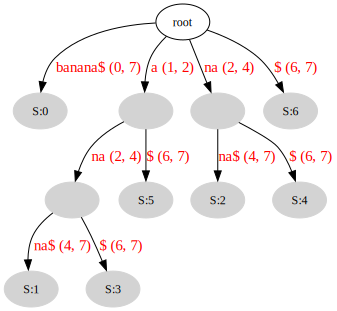

In [ ]:
# Old construction algo for comparison
suffix_tree.visualize()

In [41]:
import time 

def measure_time(func, *args, **kwargs):
    """
    Measure the time it takes to run a function
    """
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return elapsed_time, result

## Runtime test

### Testcase: only a's string

In [58]:
import matplotlib.pyplot as plt

#Size of input strings
string_lengths_a = range(100, 10000, 1000)  

runtimes_func1_a = []
runtimes_func1_a_n = []
runtimes_func1_a_n2 = []
runtimes_func2_a = []
runtimes_func2_a_n = []
runtimes_func2_a_n2 = []


for length in string_lengths_a:
    test_string = 'a' * length  #generate only a string
    
    #measure for SuffixTree
    runtime_1, suffix_tree = measure_time(SuffixTree, test_string)
    runtimes_func1_a.append(runtime_1)
    runtimes_func1_a_n.append(runtime_1/length)
    runtimes_func1_a_n2.append(runtime_1/(length*length))

    #measure for SuffixTree_mc
    runtime_2, suffix_tree = measure_time(SuffixTree_mc, test_string)
    runtimes_func2_a.append(runtime_2)
    runtimes_func2_a_n.append(runtime_2/length)
    runtimes_func2_a_n2.append(runtime_2/(length*length))

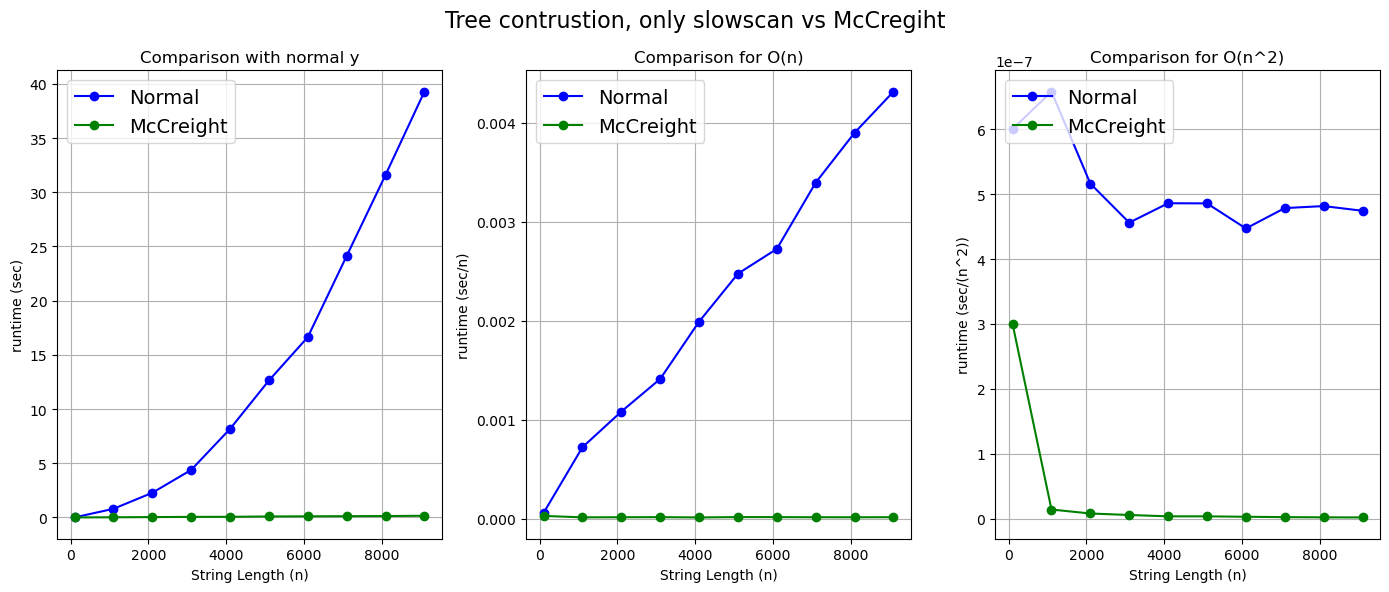

In [79]:
#create subplots:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
fig.suptitle('Tree contrustion, only slowscan vs McCregiht', fontsize=16)


# plot1 - y unmanipulated
axes[0].plot(string_lengths_a, runtimes_func1_a, marker='o', color='blue', label="Normal")
axes[0].plot(string_lengths_a, runtimes_func2_a, marker='o', color='green', label="McCreight")
axes[0].set_title('Comparison with normal y')
axes[0].set_xlabel('String Length (n)')
axes[0].set_ylabel('runtime (sec)')
#axes[0].set_ylim(0, 1)
axes[0].grid(True)
axes[0].legend(fontsize = 14, loc = "upper left")


# plot2 - y divided by n
axes[1].plot(string_lengths_a, runtimes_func1_a_n, marker='o', color='blue', label="Normal")
axes[1].plot(string_lengths_a, runtimes_func2_a_n, marker='o', color='green', label="McCreight")
axes[1].set_title('Comparison for O(n)')
axes[1].set_xlabel('String Length (n)')
axes[1].set_ylabel('runtime (sec/n)')
#axes[1].set_ylim(0, 0.0001)
axes[1].grid(True)
axes[1].legend(fontsize = 14, loc = "upper left")


# plot3 - y divided by n^2
axes[2].plot(string_lengths_a, runtimes_func1_a_n2, marker='o', color='blue', label="Normal")
axes[2].plot(string_lengths_a, runtimes_func2_a_n2, marker='o', color='green', label="McCreight")
axes[2].set_title('Comparison for O(n^2)')
axes[2].set_xlabel('String Length (n)')
axes[2].set_ylabel('runtime (sec/(n^2))')
axes[2].grid(True)
#axes[2].set_ylim(0, 0.00000005)
axes[2].legend(fontsize = 14, loc = "upper left")


#adjust layout to avoid overlap
plt.tight_layout()
plt.show()